In [52]:
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy.linalg as la
from mpl_toolkits import mplot3d

class Parameters:
    """Class for the parameters in the Neural Network."""
    def __init__(self,K,d,I,iterations):
        self.W_k = np.random.randn(K,d,d)
        self.b_k = np.random.randn(K,d,1)
        self.b_k_I = np.zeros((K,d,I))
        for i in range(K):
            self.b_k_I[i,:,:] = self.b_k[i,:,:]

        self.omega = np.random.randn(d)  
        self.my = np.random.rand()
        self.K = K
        
        # For Adam descent.
        self.beta_1 = 0.9; self.beta_2 = 0.999; self.alpha = 0.01; self.epsilon = 10E-8
        self.v = [0]; self.m = [0]
        
    # Perhaps this class should only contain the parameters 
    # and the update + root functions should be part of the Network?
    # Perhaps this makes some sense when seeing the algorithm-function after all. 
    def update_parameters(self,gradient,method,tau,j):
        """Update the parameters via Vanilla Gradient Method or Adam Descent."""
        if(method == "vanilla"):
            self.W_k = self.W_k - tau*gradient[0]
            self.b_k = self.b_k - tau*gradient[1]
            for i in range(self.K):
                self.b_k_I[i,:,:] = self.b_k[i,:,:]
            self.omega = self.omega - tau*gradient[2]
            self.my = self.my - tau*gradient[3]
            
        elif(method == "adams"):
            g = gradient 
            self.m.append( self.beta_1*self.m[j-1] + (1-self.beta_1)*g)
            self.v.append(self.beta_2*self.v[j-1]+(1-self.beta_2)*(g*g))
            m_hat = self.m[j]/(1-self.beta_1**j)
            v_hat = self.v[j]/(1-self.beta_2**j)
            subtract = self.alpha*m_hat/(self.root(self.v[j])+self.epsilon)
            
            self.W_k = self.W_k - subtract[0]
            self.b_k = self.b_k - subtract[1]
            for i in range(self.K):
                self.b_k_I[i,:,:] = self.b_k[i,:,:]
            self.omega = self.omega - subtract[2]
            self.my = self.my - subtract[3]      
                      
        else:
            print("No method found") 
    
    def root(self, v_j):
        """Calculate the root of v_j componentwise for Adam descent."""
        for i in range(4):
            v_j[i] = np.sqrt(v_j[i])
        return v_j


class Network:
    """Class for the Neural Network (ResNet)."""
    def __init__(self,K,d,I,h,Y_0,c,iterations):
        self.U = Parameters(K,d,I,iterations)
        self.Y_list = np.zeros((K+1,d,I))
        self.Y_list[0,:,:] = Y_0
        self.h = h
        self.K = K
        self.I = I
        self.d = d
        self.Z = None
    
    def J(self,Z,c): 
        """Objective function."""
        return 0.5 * la.norm(Z - c)**2
    
    def sigma(self, x):
        """Sigmoid activation function."""
        return np.tanh(x)

    def sigma_der(self, x):
        """Derivative of the sigmoid activation function."""
        val = 1-np.tanh(x)**2
        return val


    def eta(self, x):
        """Hypothesis function. Appears in the final layer of the neural network."""
        return x


    def eta_der(self, x):
        """The derivative of the hypothesis function."""
        val = 1
        return val

    def forward_function(self): 
        """Calculate and return Z."""
        for i in range(self.K):
            #jmf. formel (1) i heftet
            self.Y_list[i+1,:,:] = self.Y_list[i,:,:] + \
                self.h*self.sigma(self.U.W_k[i,:,:] @ self.Y_list[i,:,:] + self.U.b_k_I[i,:,:])
            
        YT_K = np.transpose(self.Y_list[-1,:,:]) #Enklere notasjon
        one_vec = np.ones(self.I)
        '''
        print("comp1")
        print(YT_K @ self.U.omega)
        print("comp2")
        print(self.U.my*one_vec)
        print("input Z")
        print(YT_K @ self.U.omega + self.U.my*one_vec)
        '''
        Z = self.eta(YT_K @ self.U.omega + self.U.my*one_vec)
        self.Z = Z
        return Z  #Z er en Ix1 vektor
        # Why return Z here, when it is saved as an attribute of the class? 
        # Could just take it from the object when needed instead. 
        
    
    def back_propagation(self,Z,c):
        """Calculate and return the gradient of the objective function."""
        YT_K = np.transpose(self.Y_list[-1,:,:])
        one_vec = np.ones(self.I)
        J_der_my =  np.transpose(one_vec) @ (Z-c)
        #eta_der(YT_K @ self.U.omega + self.U.my*one_vec) @ (Z-c)#Blir en skalar  
        J_der_omega = self.Y_list[-1,:,:] @ ((Z-c) * \
                            self.eta_der(YT_K @ self.U.omega + self.U.my*one_vec))
        
        P_K = np.outer(self.U.omega,(Z-c)*self.eta_der(YT_K @ \
                                            self.U.omega + self.U.my*one_vec)) #Blir en dxI matrise
        
        
        P_list = np.zeros((self.K,self.d,self.I)) #K matriser, skal ikke ha med P_0
        P_list[-1,:,:] = P_K      #Legger P_K bakerst i P_list
        for i in range(self.K-1,0,-1):  #Starter på P_k(=indeks K-1) og helt til og med P_1(=indeks 0)
            P_list[i-1,:,:] = P_list[i,:,:] + self.h*np.transpose(self.U.W_k[i-1,:,:]) @ \
            (self.sigma_der(self.U.W_k[i-1,:,:] @ self.Y_list[i-1,:,:] + \
                            self.U.b_k_I[i-1,:,:]) * P_list[i,:,:])

        J_der_W = np.zeros((self.K,self.d,self.d))
        J_der_b = np.zeros((self.K,self.d,1))
        one_vec = np.ones((self.I,1))  #Må gjøre vec_I til en matrise av en eller annen grunn
        #P_Kk går fra P_1(=indeks 0) til P_K(=indeks K-1)
        
        for i in range(self.K):
            val = P_list[i,:,:] * self.sigma_der(self.U.W_k[i,:,:] @ \
                                                 self.Y_list[i,:,:] + self.U.b_k_I[i,:,:])
            J_der_W[i,:,:] = self.h*(val @ np.transpose(self.Y_list[i,:,:]))
            J_der_b[i,:,:] = self.h*(val @ one_vec)
        
        gradient = np.array((J_der_W,J_der_b,J_der_omega,J_der_my))
        
        return gradient
    
    # SGD should be used when calculating the gradient, to reduce the computations.
    # We should at least test and see how much it affects the convergence. 
    # This does not draw without replacement however, does it?
    def stochastic_elements(self,Y_0, C, chunk): 
        """Pick out a fixed amount of elements from Z."""        
        start = np.random.randint(self.I-chunk)
        Y0_chunk = Y_0[:,start:start+chunk] 
        C_chunk = C[start:start+chunk]
        return Y0_chunk, C_chunk 

    

    
class TestFunction1D: 
    """Abstract class for testing the presented 1D test functions.
    
    This is inherited in other classes to make the concrete testing classes.
    """
    def __init__(self,domain,d0,d,I):
        self.domain = domain
        self.input = self.embed_input(d,I)
        self.solution = self.generate_solution(I)
        self.d0 = d0

    
    def embed_input(self,d,I):
        """Embed input in d-dimensional space.
        
        Done by drawing from a uniform distribution on the domain.
        """
        result = np.zeros((d,I))
        for i in range(I):
            num = np.random.uniform(self.domain[0],self.domain[1])
            result[:,i] = np.repeat(num,d)
        return result
    
    def generate_solution(self,I):
        """Generate points from the test function on the given domain."""
        result = np.zeros(I)
        for i in range(I):
            result[i] = self.f(self.input[0,i])
        return result
    
    def plot_graph(self):
        """Plot the graph of the test function on the given domain."""
        x = np.linspace(self.domain[0],self.domain[1])
        plt.plot(x,self.f(x))

class TestFunction1(TestFunction1D):
    """First given test function (in 1 dimension)."""
    def f(self, x):
        return 0.5*x**2
    
class TestFunction2(TestFunction1D):
    """Second given test function (in 1 dimension)."""
    def f(self, x):
        return 1 - np.cos(x)
 
 
class TestFunction2D:
    """Abstract class for testing the presented 2D test functions.
    
    This is inherited in other classes to make the concrete testing classes.
    """
    def __init__(self,domain,d0,d,I):
        self.domain = domain
        self.input = self.embed_input(d,I)
        self.solution = self.generate_solution(I)
        self.d0 = d0

    
    def embed_input(self,d,I):
        """Embed input in d-dimensional space.
        
        Done by drawing from a uniform distribution on the domain.
        """
        result = np.zeros((d,I))
        for i in range(I):
            num = np.random.uniform(self.domain[0][0],self.domain[0][1])
            result[:int(d/2),i] = np.repeat(num,d/2)
        for i in range(I):
            num = np.random.uniform(self.domain[1][0],self.domain[1][1])
            result[int(d/2):,i] = np.repeat(num,d/2)
            
        return result
    
    def generate_solution(self,I):
        """Generate points from the test function on the given domain."""
        result = np.zeros(I)
        for i in range(I):
            result[i] = self.f(self.input[0,i],self.input[2,i])
        return result
    
    def plot_graph(self):
        """Plot the graph of the test function on the given domain."""
        x = np.linspace(self.domain[0][0], self.domain[0][1], 30)
        y = np.linspace(self.domain[1][0], self.domain[1][1], 30)
        
        ax = plt.axes(projection='3d')
        X, Y = np.meshgrid(x, y)
        Z = self.f(X, Y)
        fig = plt.figure()
        ax.contour3D(X, Y, Z, 50, cmap='binary')
    
class TestFunction3(TestFunction2D):
    """Third given test function (in 2 dimensions)."""
    def f(self, x,y):
        return 0.5*(x**2 + y**2)

class TestFunction4(TestFunction2D):
    """Fourth given test function (in 2 dimensions)."""
    def f(self, x,y):
        return -1/np.sqrt(x**2+y**2)
    
    
# Testing the trained Neural Network with new random data.
def testing(Network,function,I,d0):
    """Testing the Neural Network with new random data. 
    
    The parameters found from the training of the Neural Network are employed.
    """
    Y_0 = function.input
    c = function.solution
    
    Y_list = np.zeros((Network.K+1,d,I))
    Y_list[0,:,:] = Y_0
    Network.Y_list = Y_list
    Z = NN.forward_function()
    
    # Plotting.
    function.plot_graph()
    if d0 == 1:
        x = Y_0[0,:]
        plt.scatter(x,Z)
    elif d0 == 2:
        ax = plt.axes(projection='3d')
        zdata = Z
        xdata = Y_0[0,:]
        ydata = Y_0[2,:]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')
    plt.show()

"""

I = 1000 # Amount of points ran through the network at once. 
K = 20 # Amount of hidden layers in the network.
d = 2 # Dimension of the hidden layers in the network. 
h = 0.1 # Scaling of the activation function application in algorithm.  
iterations = 1000
d0 = 1 # Dimensin of the input layer. 

function = TestFunction1([-2,2],d0,d,I)
#function = TestFunction2([-np.pi/3,np.pi/3],d0,d,I)
#function = TestFunction3([[-2,2],[-2,2]],d0,d,I)
#function = TestFunction4([[-1,1],[-1,1]],d0,d,I)
NN = algorithm(I,d,K,h,iterations,function,domain)

function.embed_input(d,I)
function.generate_solution(I)
function = TestFunction1([-2,2],d0,d,I)
testing(NN,function,I,d0)
"""

def algorithm(I,d,K,h,iterations,function,domain):
    """Main training algorithm."""
    tau = 0.1
      
    training_input = generate_input(function,domain,d0,I,d)
    c = get_solution(function,training_input,d)

        

    NN = Network(K,d,I,h,training_input,c,iterations)
    
    # For plotting J. 
    J_list = np.zeros(iterations)
    it = np.zeros(iterations)
    
    for j in range(1,iterations+1):
        
        Z = NN.forward_function() # See comment in forward function about returning Z. 
        #print("Z:")
        #print(Z.shape)
        
        # Tried to calculate the gradient using SGD instead, but the dimension of Z is wrong. 
        # Should not this be of dimension d x ?
        # Still think SGD could be used, but I am probably doing it wrongly.
        #Z_chunk, c_chunk = NN.stochastic_elements(Z, c, I/10)
        gradient = NN.back_propagation(Z,c)
        NN.U.update_parameters(gradient,"adams",tau,j)
        
        #print("J:")
        #print(NN.J(Z,c))
        J_list[j-1] = NN.J(Z,c)
        it[j-1] = j
        
    plt.figure()
    plt.plot(it,J_list)
    plt.ylabel("J")
    plt.xlabel("iteration")
    plt.show()
    
    return NN
        

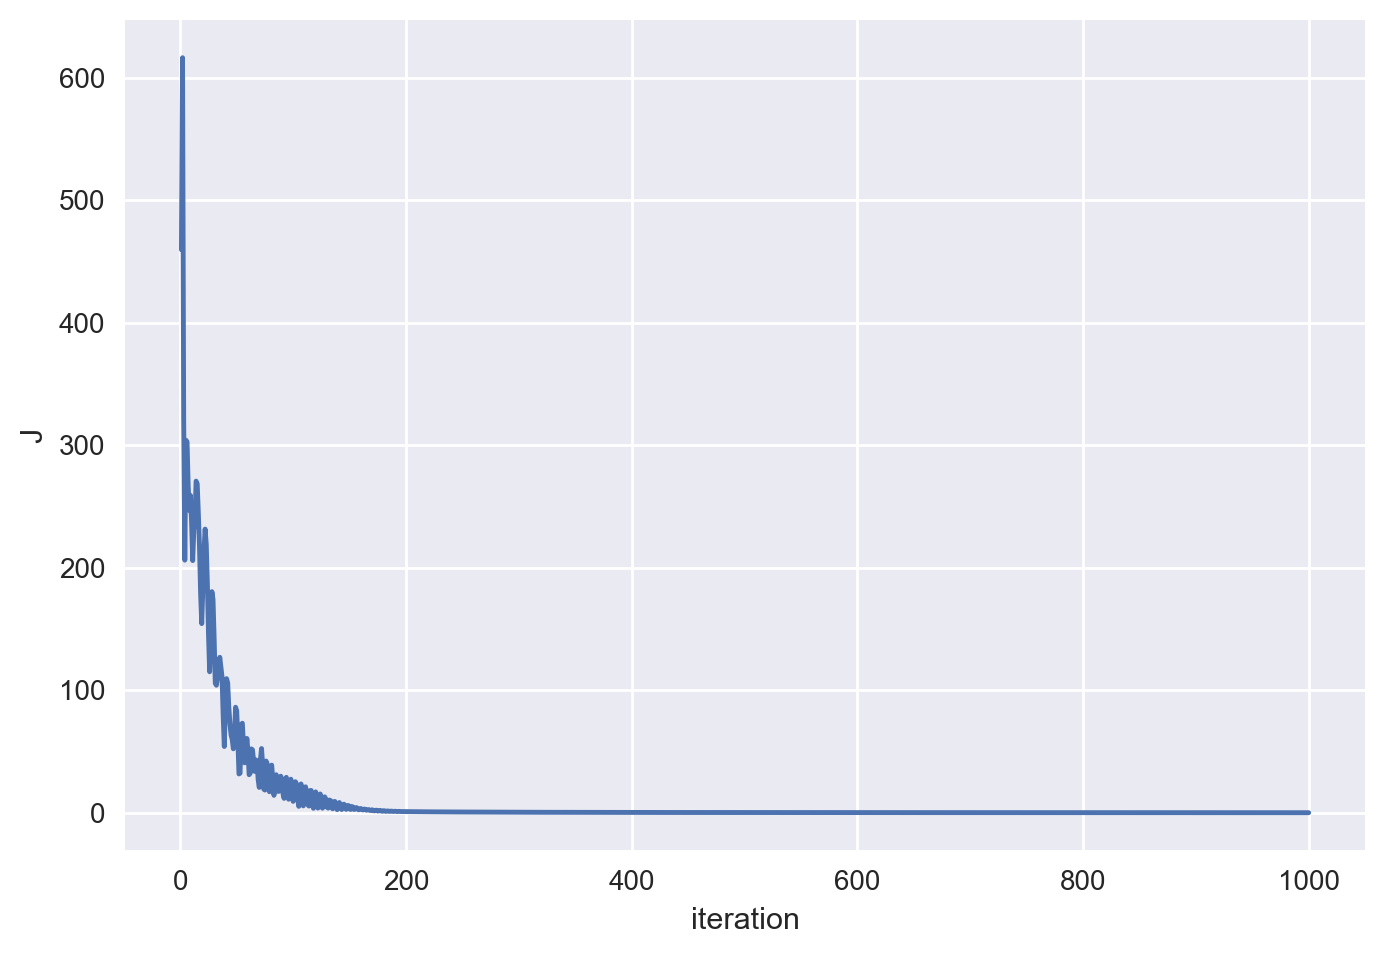

'\nd0 = 2\nd = 4\ndomain = [[-2,2],[-2,2]]\ndef test_function4(x,y):\n    return -1/np.sqrt(x**2 + y**2)\n\nNN = algorithm(I,d,K,h,iterations,test_function4,domain)\n\ntest_input = generate_input(test_function4,domain,d0,I,d)\noutput = testing(NN, test_input, test_function4, domain, d0, I)\nplot_graph_and_output(output,test_input, test_function4, domain, d0,d)\n\n'

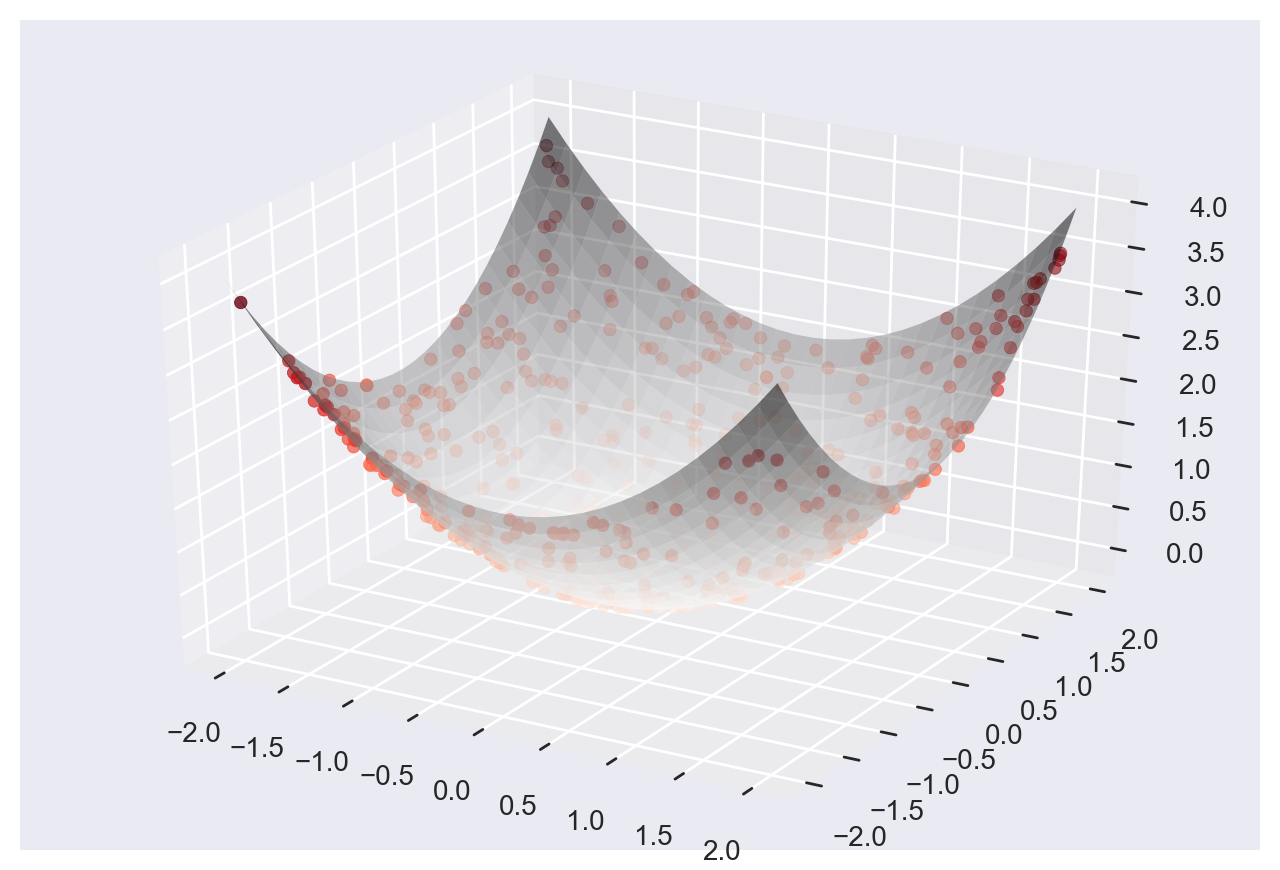

In [78]:
#Testing cell
newparams = {'figure.figsize': (15, 7), 'axes.grid': False,
             'lines.markersize': 10, 'lines.linewidth': 2,
             'font.size': 15, 'mathtext.fontset': 'stix',
             'font.family': 'STIXGeneral', 'figure.dpi': 200}
plt.rcParams.update(newparams)

plt.style.use('seaborn')

def testing(Network, test_input, function, domain, d0, I):
    """Testing the Neural Network with new random data. 
    
    The parameters found from the training of the Neural Network are employed.
    """
    c = get_solution(function, test_input, d)
    
    Y_list = np.zeros((Network.K+1,d,I))
    Y_list[0,:,:] = test_input
    Network.Y_list = Y_list
    output = Network.forward_function()
    
    return output 


def generate_input(function,domain,d0,I,d):
    """Generate and embed input in d-dimensional space.
        Done by drawing from a uniform distribution on the domain.
    """
    result = np.zeros((d,I))
    if d0 == 1:
        for i in range(I):
            num = np.random.uniform(domain[0],domain[1])
            result[:,i] = np.repeat(num,d)
        return result
    if d0 ==2:
        for i in range(I):
            num = np.random.uniform(domain[0][0],domain[0][1])
            result[:int(d/2),i] = np.repeat(num,d/2)
        for i in range(I):
            num = np.random.uniform(domain[1][0],domain[1][1])
            result[int(d/2):,i] = np.repeat(num,d/2)

    return result


def get_solution(function,input_values,d):
    """Generate points from the test function on the given domain.
    """
    result = np.zeros(I)
    if d0 == 1:
        for i in range(I):
            result[i] = function(input_values[0,i])
        
    if d0 == 2:
        for i in range(I):
            result[i] = function(input_values[0,i],input_values[int(d/2),i])
    return result
    

def plot_graph_and_output(output,input,function,domain,d0,d):
    if d0 == 1:
        #Plotting the output from the network.
        x = input[0,:]
        plt.scatter(x,output)

        #Plotting the analytical solution
        x = np.linspace(domain[0],domain[1])
        plt.plot(x,function(x))
        plt.show()
    elif d0 == 2:
        #Plotting output
        ax = plt.axes(projection='3d')
        zdata = output
        xdata = input[0,:]
        ydata = input[int(d/2),:]
        ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Reds')
        
        #Plotting analytical graph
        x = np.linspace(domain[0][0],domain[0][1], 30)
        y = np.linspace(domain[1][0], domain[1][1], 30)
        
        X, Y = np.meshgrid(x, y)
        Z = function(X, Y)

        ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                cmap='Greys', edgecolor='none', alpha = 0.5)



I = 500 # Amount of points ran through the network at once. 
K = 20 # Amount of hidden layers in the network.
d = 2 # Dimension of the hidden layers in the network. 
h = 0.1 # Scaling of the activation function application in algorithm.  
iterations = 1000

#================#
#Test function 1 #
#================#

"""

d0 = 1 # Dimensin of the input layer. 
domain = [-2,2]
def test_function1(x):
    return 0.5*x**2

NN = algorithm(I,d,K,h,iterations,test_function1,domain)
test_input = generate_input(function,domain,d0,I,d)
output = testing(NN, test_input, test_function1, domain, d0, I)
plot_graph_and_output(output, test_input, test_function1, domain, d0,d)

"""
#================#
#Test function 2 #
#================#
""""

d0 = 1 # Dimensin of the input layer. 
domain = [-2,2]
def test_function2(x):
    return 1 - np.cos(x)

NN = algorithm(I,d,K,h,iterations,test_function2,domain)
test_input = generate_input(test_function2,domain,d0,I,d)
output = testing(NN, test_input, test_function2, domain, d0, I)
plot_graph_and_output(output,test_input, test_function2, domain, d0,d)
"""
#================#
#Test function 3 #
#================#



d0 = 2
d = 4
domain = [[-2,2],[-2,2]]
def test_function3(x,y):
    return 0.5*(x**2 + y**2)

NN = algorithm(I,d,K,h,iterations,test_function3,domain)

test_input = generate_input(test_function3,domain,d0,I,d)
output = testing(NN, test_input, test_function3, domain, d0, I)
plot_graph_and_output(output,test_input, test_function3, domain, d0,d)


#================#
#Test function 4 #
#================#
"""
d0 = 2
d = 4
domain = [[-2,2],[-2,2]]
def test_function4(x,y):
    return -1/np.sqrt(x**2 + y**2)

NN = algorithm(I,d,K,h,iterations,test_function4,domain)

test_input = generate_input(test_function4,domain,d0,I,d)
output = testing(NN, test_input, test_function4, domain, d0, I)
plot_graph_and_output(output,test_input, test_function4, domain, d0,d)

"""



    





In [34]:
def f(name):
    print(name)
    
def printf(function):
    return function("Hilbert")

printf(f)

Hilbert
